In [17]:
from transplant.datasets.icentia11k import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.signal import ShortTimeFFT
from pprint import pprint

# valid patient ids in small unzipped dataset: [0, 1, 88, 89, 96, 97, 98, 99, 100, 109, 166, 167, 168, 186, 187, 188, 189, 190, 191, 196, 197, 221, 222, 223, 236]
patient_id = 1
# db_dir = 'data/icentia11k_subset'
# patient_data = load_patient_data(db_dir, patient_id, unzipped=False)
db_dir = 'data/icentia11k_subset_unzipped'
(ecg_signal, labels) = load_patient_data(db_dir, patient_id, include_labels=True, unzipped=True)

# lets explore the data a bit
print(len(ecg_signal))
print(ecg_signal)

print(labels.keys())
print(len(labels["btype"]))
print(labels["btype"][1])

50
[[-0.06723609 -0.08068331 -0.09413053 ...  0.01344722 -0.02689444
  -0.08068331]
 [-0.09413053 -0.08068331 -0.02689444 ...  0.10757775  0.13447218
   0.1479194 ]
 [ 0.1479194   0.1479194   0.16136663 ...  0.16136663  0.17481384
   0.18826106]
 ...
 [ 0.08068331  0.06723609  0.05378887 ...  0.08068331  0.04034166
  -0.01344722]
 [-0.06723609 -0.04034166  0.02689444 ... -0.01344722 -0.01344722
  -0.01344722]
 [-0.01344722 -0.01344722 -0.01344722 ... -0.17481384 -0.17481384
  -0.06723609]]
dict_keys(['btype', 'rtype'])
50
(array([    149,     325,     509, ..., 1048160, 1048341, 1048524],
      dtype=int32), array([1, 1, 1, ..., 0, 0, 0]))


twindow is 52.0 with N 13000 and fsample 250.0


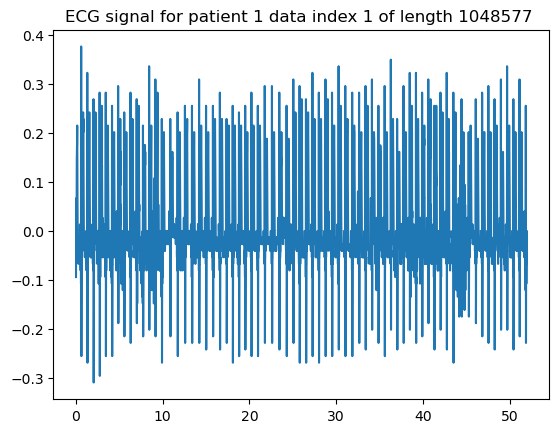

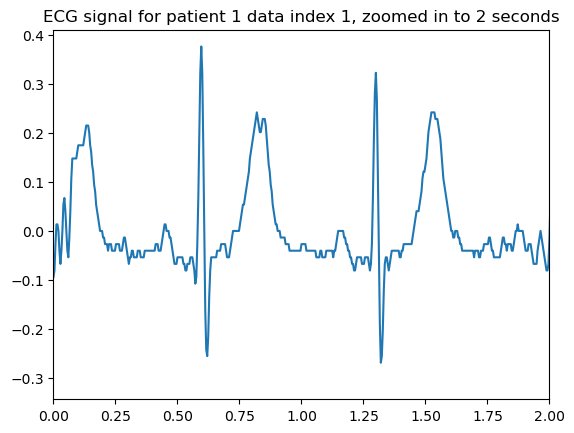

In [19]:
# lets select a portion of the signal and plot it in timedomain
# ideally, the data size should be selected so that the spectogram output is 64xM, 
# where M >64. and so that when we select the 64 lowest frequencies, this corresponds to 0-40Hz
data_idx = 1;
fsample = 250.0;
T_x = 1.0/fsample
window_size = 400
stride=200
output_size = 64
N = stride*(output_size-1) + window_size# adjust stride/output_size/window size so this is approximately 100*250
twindow = N/fsample
print(f"twindow is {twindow} with N {N} and fsample {fsample}")
t_x = np.arange(N) * T_x 
selected_signal =ecg_signal[data_idx][:N];

# lets plot signal
plt.plot(t_x, selected_signal)
# print title with info on length
title = f"ECG signal for patient {patient_id} data index {data_idx} of length {len(ecg_signal[data_idx])} "
plt.title(title)
plt.show()

# and now zoomed in
plt.plot(t_x, selected_signal)
plt.xlim([0, 2])
title = f"ECG signal for patient {patient_id} data index {data_idx}, zoomed in to 2 seconds"
plt.title(title)
plt.show()


size of Sx is (201, 66)


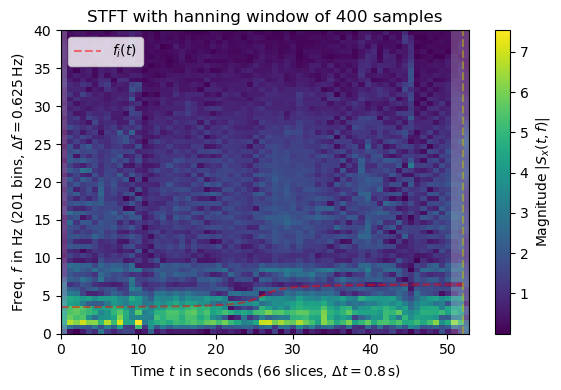

In [23]:
# lets compute an short time fft  (spectogram) with  window of 400 for each fft (1.6 seconds)
# sampling frequency is 250Hz

# chose a hanning window
# this is like a 1D convolution, that helps smooth out the spectogram across
# time and frequency
f_i = 1 * np.arctan((t_x - t_x[N // 2]) / 2) + 5  # varying frequency
w = np.hanning(window_size)
# g_std = 8  # standard deviation for Gaussian window in samples
# w = signal.windows.gaussian(window_size, std=g_std, sym=True)  # symmetric Gaussian window

# lets do the actual spectogram (series of fft frequency decompositions over time)
SFT = ShortTimeFFT(w, hop=stride, fs=1/T_x);
Sx = SFT.stft(selected_signal)
print(f"size of Sx is {Sx.shape}")

# lets plot the spectogram
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT with hanning window of {window_size} samples")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
# should probably not use these in the future....
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
ax1.legend()
fig1.tight_layout()

# zoom into 0 to 40Hz on y axis (this seems to be where the action is)
ax1.set_ylim(0, 40)
plt.show()

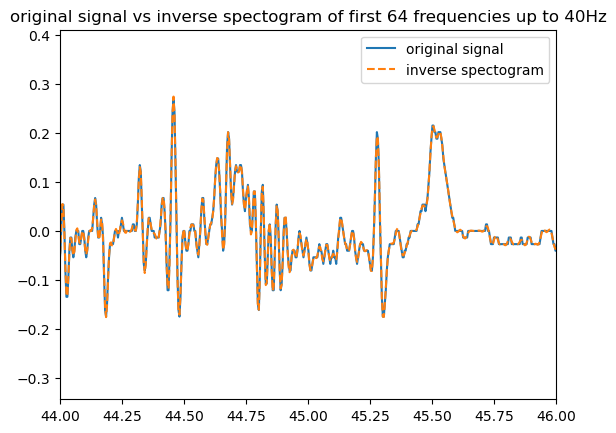

In [24]:
# Now lets see how good the spectogram captures the information in the time-domain signal
# we can do this by inverting the spectogram back to the time-domain signal
# Specifically, lets say we only want to keep lowest 64 frequencies (0-40Hz)
# we do this by setting elements 64:end,: to zero
Sx[output_size:,:] = 0

# now lets calculate the inverse SFT
SFT.invertible  # check if invertible
x1 = SFT.istft(Sx, k1=N)
np.allclose(selected_signal, x1)

plt.plot(t_x, selected_signal, t_x, x1, '--')
# print title with info on output size (how many frequencies we kept)
title = "original signal vs inverse spectogram of first {} frequencies up to {}Hz".format(output_size, int(SFT.delta_f*output_size))
plt.legend(["original signal", "inverse spectogram"])
plt.xlim(44,46)
plt.title(title)
plt.show()
